In [1]:
%load_ext autoreload
%autoreload 2

# 1. Imports and Setup

In [6]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("..")

from src.core.strategy import Strategy
from src.core.backtest import run_backtest

# 2. Load and Clean Data

In [7]:
data_path = "../data/btc_hour.csv"
df = pd.read_csv(data_path)
df['time'] = pd.to_datetime(df['time'])

# Keep only the columns we need
df = df[['time', 'close', 'volumeto']].copy()
df = df.rename(columns={'volumeto': 'volume'})
df.head()

,time,close,volume
0,2011-11-28 00:00:00+00:00,2.497,8571.74
1,2011-11-28 01:00:00+00:00,2.498,1698.15
2,2011-11-28 02:00:00+00:00,2.487,1559.13
3,2011-11-28 03:00:00+00:00,2.442,6519.05
4,2011-11-28 04:00:00+00:00,2.462,10667.19


# 3. Import Your Strategy

In [9]:
import importlib.util

# Change this to your strategy file
strategy_path = "../src/strategies/athon_sma-v1.py"

spec = importlib.util.spec_from_file_location("my_strategy", strategy_path)
my_strategy_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(my_strategy_module)

# Find the strategy class (assumes only one subclass of Strategy in the file)
strategy_class = next(
    obj for name, obj in my_strategy_module.__dict__.items()
    if isinstance(obj, type) and issubclass(obj, Strategy) and obj is not Strategy
)

# 4. Run Backtest

In [10]:
results = run_backtest(strategy_class, df, initial_capital=10000)

# 5. Display Metrics

In [11]:
def print_metrics(name, results):
    print(f"--- {name} ---")
    print(f"Sharpe Ratio: {results['sharpe']:.2f}")
    print(f"Total Return: {results['total_return']*100:.2f}%")
    print(f"Annualized Return: {results['annualized_return']*100:.2f}%")
    print(f"Max Drawdown: {results['max_drawdown']*100:.2f}%")
    print(f"Number of Trades: {results['n_trades']}")
    print(f"Win Rate: {results['win_rate']*100:.2f}%")
    print()

print_metrics(strategy_class.__name__, results)

--- SMACrossoverStrategy ---
Sharpe Ratio: 1.21
Total Return: 388766.50%
Annualized Return: 84.66%
Max Drawdown: 97.10%
Number of Trades: 808
Win Rate: 39.85%



# 6. Plot Results

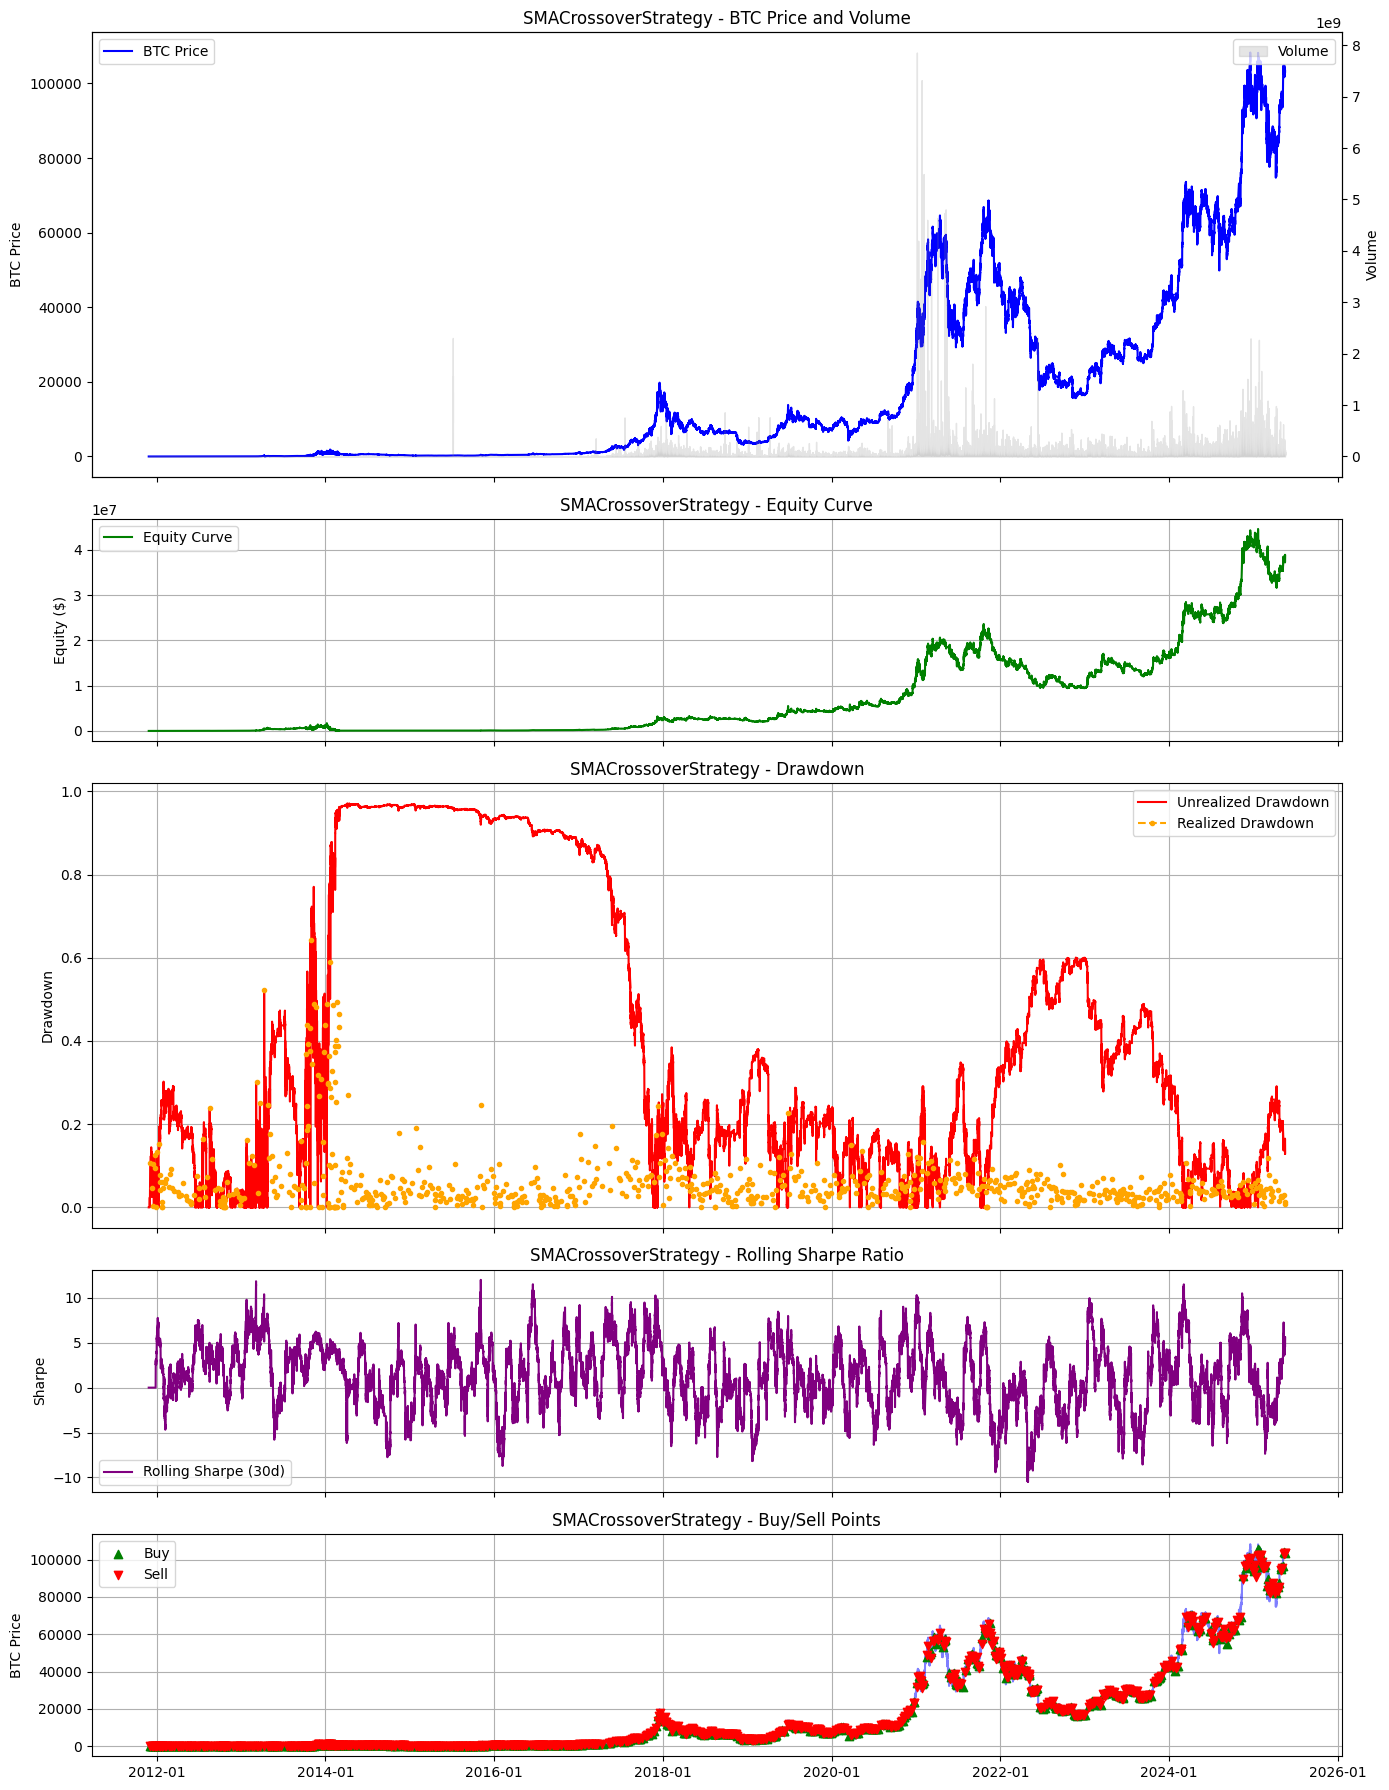

In [15]:
import matplotlib.dates as mdates

def plot_strategy_results(df, results, name="Strategy"):
    # Align index for plotting
    times = pd.to_datetime(df['time'])
    equity = results['equity_curve'].reset_index(drop=True)
    rolling_sharpe = results['rolling_sharpe'].reset_index(drop=True)
    unrealized_dd = results['unrealized_drawdown'].reset_index(drop=True)
    realized_dd = results['realized_drawdown'].reset_index(drop=True)

    fig, axs = plt.subplots(5, 1, figsize=(14, 18), sharex=True, gridspec_kw={'height_ratios': [2, 1, 2, 1, 1]})

    # 1. Price and Volume
    axs[0].plot(times, df['close'], label='BTC Price', color='blue')
    ax2 = axs[0].twinx()
    ax2.fill_between(times, df['volume'], color='gray', alpha=0.2, label='Volume')
    axs[0].set_ylabel('BTC Price')
    ax2.set_ylabel('Volume')
    axs[0].set_title(f"{name} - BTC Price and Volume")
    axs[0].legend(loc='upper left')
    ax2.legend(loc='upper right')

    # 2. Equity Curve
    axs[1].plot(times, equity[:len(times)], label='Equity Curve', color='green')
    axs[1].set_ylabel('Equity ($)')
    axs[1].set_title(f"{name} - Equity Curve")
    axs[1].legend()
    axs[1].grid(True)

    # 3. Drawdown
    axs[2].plot(times, unrealized_dd[:len(times)], label='Unrealized Drawdown', color='red')
    axs[2].plot(times, realized_dd[:len(times)], label='Realized Drawdown', color='orange', linestyle='--', marker='o', markersize=3)
    axs[2].set_ylabel('Drawdown')
    axs[2].set_title(f"{name} - Drawdown")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Rolling Sharpe
    axs[3].plot(times, rolling_sharpe[:len(times)], label='Rolling Sharpe (30d)', color='purple')
    axs[3].set_ylabel('Sharpe')
    axs[3].set_title(f"{name} - Rolling Sharpe Ratio")
    axs[3].legend()
    axs[3].grid(True)

    # 5. Trades (Buy/Sell markers)
    axs[4].plot(times, df['close'], color='blue', alpha=0.5)
    # Only keep indices that are within the bounds of df/times
    buys = [idx for idx in [t['entry_idx'] for t in results['trades']] if idx < len(df)]
    sells = [idx for idx in [t['exit_idx'] for t in results['trades']] if idx < len(df)]

    axs[4].scatter(times.iloc[buys], df['close'].iloc[buys], marker='^', color='green', label='Buy', zorder=5)
    axs[4].scatter(times.iloc[sells], df['close'].iloc[sells], marker='v', color='red', label='Sell', zorder=5)
    axs[4].set_ylabel('BTC Price')
    axs[4].set_title(f"{name} - Buy/Sell Points")
    axs[4].legend()
    axs[4].grid(True)

    # X-axis formatting
    axs[-1].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_strategy_results(df, results, name=strategy_class.__name__)

---
---